# Imports

In [100]:
# Standard Imports
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pandas as pd
import torch
import os

# Ch 2 Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import *
from sklearn.metrics import accuracy_score

# Ch 3 Imports
import torchvision
from torchvision import transforms

# Now you can import your file just like any other library
import sys
sys.path.append('../Inside-Deep-Learning/')

from idlmam import *


In [101]:
if torch.cuda.is_available():
   device = torch.device("cuda")
   B = 32
   epochs = 20
   num_workers_data_loaders = 2
elif torch.xpu.is_available():
   device = torch.device("xpu")
   B = 32
   epochs = 20
   num_workers_data_loaders = 2
else:
   device = torch.device("cpu")
   B = 1
   epochs = 5
   num_workers_data_loaders = 1

print(device)

xpu


In [17]:
train_data = torchvision.datasets.FashionMNIST("./", train=True,
 transform=transforms.ToTensor(), download=True)
test_data = torchvision.datasets.FashionMNIST("./", train=True,
 transform=transforms.ToTensor(), download=True)

train_loader = DataLoader(train_data, batch_size=256, shuffle=True)
test_loader = DataLoader(test_data, batch_size=256)

In [18]:
W, H = 28, 28
D = 28*28
n = 128
C = 1
n_filters = 32
classes = 10

In [19]:
leak_rate = 0.1

In [ ]:
results = {}

In [ ]:
for BN in [False, True]:
    for prelu in [True, False]:
        model = nn.Sequential(
            cnnLayer(C, n_filters, batch_norm=BN, prelu=prelu),
            cnnLayer(n_filters, batch_norm=BN, prelu=prelu),
            cnnLayer(n_filters, batch_norm=BN, prelu=prelu),
            nn.MaxPool2d((2,2)),

            cnnLayer(n_filters, 2*n_filters, batch_norm=BN, prelu=prelu),
            cnnLayer(2*n_filters, batch_norm=BN, prelu=prelu, pool_factor=1),
            cnnLayer(2*n_filters, batch_norm=BN, prelu=prelu, pool_factor=1),
            nn.MaxPool2d((2,2)),

            cnnLayer(2*n_filters, 4*n_filters, batch_norm=BN, prelu=prelu, pool_factor=2),
            cnnLayer(4*n_filters, batch_norm=BN, prelu=prelu, pool_factor=2),
            nn.Flatten(),
            nn.Linear(D*n_filters//4, classes),
        )

        norm = "BN" if BN else "LN"
        activation = "PReLU" if prelu else "ReLU"
        name = f"CNN with BN, ReLU={prelu}"

        results[name] = train_network(model, loss_func, train_loader,
                                                            test_loader=test_loader, epochs=2,
                                                            score_funcs={'Accuracy': accuracy_score}, device=device)
        
        del model

In [ ]:
for name in results.keys():
    sns.lineplot(x='epoch', y='test Accuracy', data=results[name],
     label=name)

# 2\. Write a for loop to train CNN models with 1 to 20 sets of hidden layers, once with BN layers and one without. How does BN impact the ability to learn deeper models?

In [7]:
results_ex2 = {}

In [37]:
def create_cnn_no_pool(D, C, classes, num_hidden_layers=0, n_filters=16, BN=True):
    # Input Layer
    sequential_layers = [
        cnnLayer(C, n_filters, batch_norm=BN),
    ]

    # Hidden Layers
    for layer in range(num_hidden_layers):
            sequential_layers.append( cnnLayer(n_filters, batch_norm=BN) )
    
    # Ouput Layer
    expected_size = D*n_filters
    sequential_layers.append( nn.Flatten() )
    sequential_layers.append( nn.Linear(expected_size, classes) )

    return nn.Sequential(*sequential_layers)


def create_cnn_with_pool(D, C, classes, num_hidden_layers=0, n_filters=16, BN=True):
    # Input Layer
    sequential_layers = [
        cnnLayer(C, n_filters, batch_norm=BN),
    ]

    # Hidden Layers
    count = 1
    count_pool = 0
    new_n_filters = n_filters
    for layer in range(num_hidden_layers):
        # cnnLayer(n_filters, 2*n_filters),
        if count == 0:
            sequential_layers.append( cnnLayer(new_n_filters//2, new_n_filters, batch_norm=BN) )
            count += 1

        # cnnLayer(n_filters),
        elif count == 1:
            sequential_layers.append( cnnLayer(new_n_filters, batch_norm=BN) )
            count += 1

        # cnnLayer(n_filters) + pooling
        elif count == 2:
            sequential_layers.append( cnnLayer(new_n_filters) )
            sequential_layers.append( nn.MaxPool2d((2,2)) )
            count = 0
            count_pool += 1
            new_n_filters *= (2 ** count_pool)

    # Ouput Layer
    expected_size = D*new_n_filters//(4**count_pool)
    print(D,new_n_filters,count_pool)
    sequential_layers.append( nn.Flatten() )
    sequential_layers.append( nn.Linear(expected_size, classes) )

    return nn.Sequential(*sequential_layers)

In [33]:
(784*32)//4

6272

In [ ]:
model = create_cnn_no_pool(D, C, 10, num_hidden_layers=3)
print(model)
del model

Epoch: 100%|██████████| 2/2 [02:33<00:00, 76.84s/it]


<Axes: xlabel='epoch', ylabel='test Accuracy'>

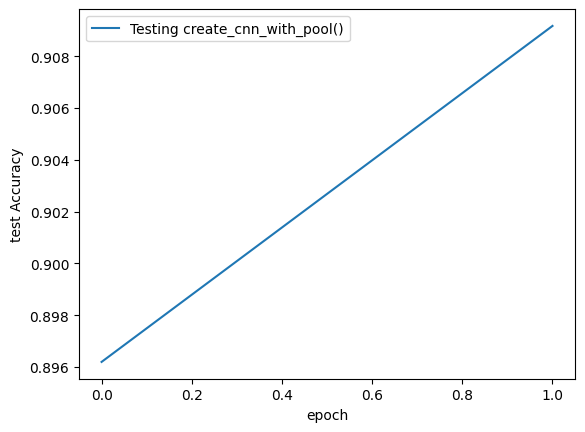

In [41]:
model = create_cnn_no_pool(D, C, 10, num_hidden_layers=20)
loss_func = nn.CrossEntropyLoss()

test_results = train_network(model, loss_func, train_loader,
                            test_loader=test_loader, epochs=2,
                            score_funcs={'Accuracy': accuracy_score}, device=device)
        
del model

sns.lineplot(x='epoch', y='test Accuracy', data=test_results,
     label='Testing create_cnn_with_pool()')

In [ ]:
for i in range(1, 21):
    print(i)
    model = nn.Sequential(
            cnnLayer(C, n_filters, batch_norm=BN, prelu=prelu),
            cnnLayer(n_filters, batch_norm=BN, prelu=prelu),
            cnnLayer(n_filters, batch_norm=BN, prelu=prelu),
            nn.MaxPool2d((2,2)),

            cnnLayer(n_filters, 2*n_filters, batch_norm=BN, prelu=prelu),
            cnnLayer(2*n_filters, batch_norm=BN, prelu=prelu, pool_factor=1),
            cnnLayer(2*n_filters, batch_norm=BN, prelu=prelu, pool_factor=1),
            nn.MaxPool2d((2,2)),

            cnnLayer(2*n_filters, 4*n_filters, batch_norm=BN, prelu=prelu, pool_factor=2),
            cnnLayer(4*n_filters, batch_norm=BN, prelu=prelu, pool_factor=2),
            nn.Flatten(),
            nn.Linear(D*n_filters//4, classes),
        )


# 3\. 

# 4\. Re-implement the `ResidualBlockE` for fully connected layers instead of convolutional layers. Does making the fully connected model use residual connections still improve performance?

In [41]:
class ResidualBottleNeck(nn.Module): 
    def __init__(self, in_channels, out_channels, 
     kernel_size=3, leak_rate=0.1):

        super().__init__() 
        pad = (kernel_size-1)//2
        bottleneck = max(out_channels//4, in_channels)


        self.F = nn.Sequential( 
                nn.BatchNorm2d(in_channels),
                nn.LeakyReLU(leak_rate), 
                nn.Conv2d(in_channels, bottleneck, 1, padding=0), 

                nn.BatchNorm2d(bottleneck),
                nn.LeakyReLU(leak_rate), 

                nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad), 

                nn.BatchNorm2d(bottleneck),                #3
                nn.LeakyReLU(leak_rate), 
                nn.Conv2d(bottleneck, out_channels, 1, padding=0) 
            )


        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential( 
                nn.Conv2d(in_channels, out_channels, 1, padding=0), 
                nn.BatchNorm2d(out_channels) 
            )

    def forward(self, x): 
        return self.shortcut(x) + self.F(x)

In [24]:
class ResidualBlockE(nn.Module): 
    def __init__(self, channels, kernel_size=3, leak_rate=0.1): 
        """ 
        channels: how many channels are in the input/output to this layer 
        kernel_size: how large of a filter should we use 
        leak_rate: parameter for the LeakyReLU activation function 
        """
        super().__init__() 
        pad = (kernel_size-1)//2
        self.F = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size, padding=pad), 
            nn.BatchNorm2d(channels), 
            nn.LeakyReLU(leak_rate), 
            nn.Conv2d(channels, channels, kernel_size, padding=pad), 
            nn.BatchNorm2d(channels), 
            nn.LeakyReLU(leak_rate), 
        ) 
    def forward(self, x): 
        return x + self.F(x)

In [ ]:
class ResidualBlockELinear(nn.Module): 
    def __init__(self, channels, leak_rate=0.1): 
        """ 
        channels: how many channels are in the input/output to this layer 
        kernel_size: how large of a filter should we use 
        leak_rate: parameter for the LeakyReLU activation function 
        """
        super().__init__() 
        neurons = 256
        i
        self.F = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels, neurons), 
            nn.BatchNorm2d(neurons), 
            nn.LeakyReLU(leak_rate), 

            nn.Linear(neurons, channels), 
            nn.BatchNorm2d(channels), 
            nn.LeakyReLU(leak_rate), 
        ) 
    def forward(self, x):
        F_x = self.F(x).view(B, -1, H, W)
        print(F_x.shape)
        return x + F_x

In [79]:
filter_size = 3

model = nn.Sequential(
    nn.Conv2d(C, n_filters, filter_size, padding=(filter_size-1)//2), 
    nn.BatchNorm2d(n_filters),
    nn.LeakyReLU(leak_rate), 
    
    ResidualBlockELinear(n_filters),
    nn.LeakyReLU(leak_rate), 
    nn.Flatten(), 
    nn.Linear(n_filters, classes), 
)
print(model)

# del model 

Sequential(
  (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): LeakyReLU(negative_slope=0.1)
  (3): ResidualBlockELinear(
    (F): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=32, out_features=256, bias=True)
      (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): LeakyReLU(negative_slope=0.1)
      (4): Linear(in_features=256, out_features=32, bias=True)
      (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): LeakyReLU(negative_slope=0.1)
    )
  )
  (4): LeakyReLU(negative_slope=0.1)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=32, out_features=10, bias=True)
)


In [80]:
loss_func = nn.CrossEntropyLoss()

test_results = train_network(model, loss_func, train_loader,
                            test_loader=test_loader, epochs=2,
                            score_funcs={'Accuracy': accuracy_score}, device=device)
        
del model

sns.lineplot(x='epoch', y='test Accuracy', data=test_results,
     label='Testing create_cnn_with_pool()')

Epoch:   0%|          | 0/2 [00:00<?, ?it/s]


RuntimeError: mat1 and mat2 shapes cannot be multiplied (256x25088 and 32x256)

In [67]:
25088 / D

32.0

# 5\. Write a for loop to train a residual model with progressively more combinations of `ResidualBlockE` layers. Do the residual blocks allow you to train even deeper models?

In [83]:
def create_cnn_res_model(num_res_block_e_layers):
    layers = []
    for _ in range(num_res_block_e_layers):
        layers.append( ResidualBlockE(2*n_filters) )
        layers.append( nn.LeakyReLU(leak_rate) )

    return nn.Sequential( 
    ResidualBottleNeck(C, n_filters),
    nn.LeakyReLU(leak_rate),
    nn.MaxPool2d((2,2)), 
    ResidualBottleNeck(n_filters, 2*n_filters), 
    nn.LeakyReLU(leak_rate), 
    
    *layers, 
    
    nn.Flatten(), 
    nn.Linear(D*2*n_filters//4, classes), 
)

model = create_cnn_res_model(10)

loss_func = nn.CrossEntropyLoss()

test_results = train_network(model, loss_func, train_loader,
                            test_loader=test_loader, epochs=2,
                            score_funcs={'Accuracy': accuracy_score}, device=device)
        
del model

sns.lineplot(x='epoch', y='test Accuracy', data=test_results,
     label='Testing create_cnn_with_pool()')

Epoch:   0%|          | 0/2 [00:04<?, ?it/s]


KeyboardInterrupt: 

# 6\. Try creating a bidirectional LSTM layer. Do you get better or worse results?

In [102]:
zip_file_url = "https://download.pytorch.org/tutorial/data.zip"

import requests, zipfile, io
r = requests.get(zip_file_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

In [103]:
namge_language_data = {}

import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)
alphabet = {}
for i in range(n_letters):
    alphabet[all_letters[i]] = i

def unicodeToAscii(s):
    return "".join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

for zip_path in z.namelist():

    if "data/names/" in zip_path and zip_path.endswith(".txt"):
        lang = zip_path[len("data/names/"):-len(".txt")]
        with z.open(zip_path) as myfile:
            lang_names = [unicodeToAscii(line).lower()
             for line in
             str(myfile.read(), encoding='utf-8').strip().split("\n")]
            namge_language_data[lang] = lang_names
        print(lang, ": ", len(lang_names))

Arabic :  2000
Chinese :  268
Czech :  519
Dutch :  297
English :  3668
French :  277
German :  724
Greek :  203
Irish :  232
Italian :  709
Japanese :  991
Korean :  94
Polish :  139
Portuguese :  74
Russian :  9408
Scottish :  100
Spanish :  298
Vietnamese :  73


In [107]:
dataset = LanguageNameDataset(namge_language_data, alphabet)

train_lang_data, test_lang_data = torch.utils.data.random_split(dataset, 
 (len(dataset)-300, 300)) 
train_lang_loader = DataLoader(train_lang_data, batch_size=32, 
 shuffle=True, collate_fn=pad_and_pack) 
test_lang_loader = DataLoader(test_lang_data, batch_size=32, 
 shuffle=False, collate_fn=pad_and_pack)

D = 64

In [113]:
for bidirectional in [True, False]:
    num_hidden_nodes = 256
    model = nn.Sequential(
        EmbeddingPackable(
            nn.Embedding(len(all_letters), D)
        ),

        nn.LSTM(D, num_hidden_nodes, num_layers=3, batch_first=True, bidirectional=bidirectional),

        LastTimeStep(rnn_layers=3, bidirectional=bidirectional),
        nn.Linear(num_hidden_nodes*(2**bidirectional), len(namge_language_data)),
    )

    for p in model.parameters():
        p.register_hook(lambda grad: torch.clamp(grad, -5, 5))

    rnn_results = train_network(model, loss_func, train_lang_loader, 
                                test_loader=test_lang_loader, 
                                score_funcs={"Accuracy": accuracy_score},
                                device=device, epochs=2)

    del model

    name = "Bidirectional RNN" if bidirectional else "Baseline RNN"

    sns.lineplot(x='epoch', y='test Accuracy', data=rnn_results, label=name)

Epoch:   0%|          | 0/2 [00:05<?, ?it/s]


KeyboardInterrupt: 

# 7\. Try training various LSTM and GRU networks with varying numbers of layers and neurons, and compare them in terms of the time to reach a desired accuracy level. Do you see any relative pros or cons of each?

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 100%|██████████| 10/10 [19:41<00:00, 118.16s/it]


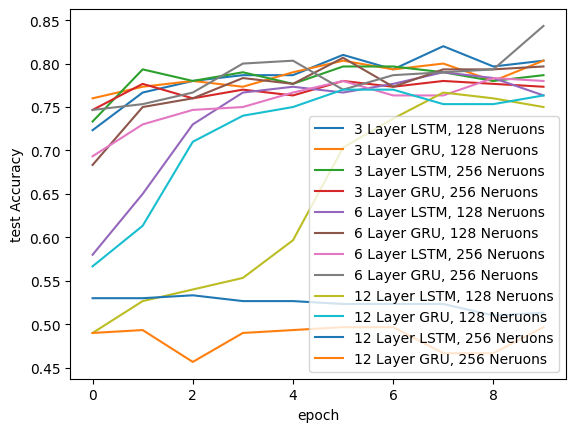

In [116]:
for num_layers in [3, 6, 12]:
    for num_neurons in [128, 256]:
        for module in ["LSTM", "GRU"]:

            if module == "LSTM":
                model = nn.Sequential(
                    EmbeddingPackable(nn.Embedding(len(all_letters), D)),
                    nn.LSTM(D, num_neurons, num_layers=num_layers, batch_first=True),
                    LastTimeStep(rnn_layers=num_layers),
                    nn.Linear(num_neurons, len(namge_language_data)),
                )
            else:
                model = nn.Sequential(
                    EmbeddingPackable(nn.Embedding(len(all_letters), D)),
                    nn.GRU(D, num_neurons, num_layers=num_layers, batch_first=True),
                    LastTimeStep(rnn_layers=num_layers),
                    nn.Linear(num_neurons, len(namge_language_data)),
                )

            for p in model.parameters():
                p.register_hook(lambda grad: torch.clamp(grad, -5, 5))

            rnn_results = train_network(model, loss_func, train_lang_loader, 
                                        test_loader=test_lang_loader, 
                                        score_funcs={"Accuracy": accuracy_score},
                                        device=device, epochs=10)

            del model

            name = f"{num_layers} Layer {module}, {num_neurons} Neruons"

            sns.lineplot(x='epoch', y='test Accuracy', data=rnn_results, label=name)